In this notebook we make the figure with all the target spectra


In [1]:
import time
import os.path
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from datetime import timedelta
from tenacity import retry, stop_after_attempt
import glob
import scipy as sc
import csaps

import sys, errno  


In [2]:

palette = sns.color_palette()
plt.style.use(['seaborn-colorblind'])
plt.rc('font', family='Arial')
SMALL_SIZE = 12
BIGGER_SIZE = 13
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 1

savefigs_path = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AFKABAN'
one_col = 85 *0.0393701
two_col = 170*0.0393701

In [4]:
a_tilt_df = pd.read_feather(f'{apath}/a_tilt_df.feather')
p_tilt_df = pd.read_feather(f'{ppath}/p_tilt_df.feather')
p2_tilt_df = pd.read_feather(f'{p2path}/p2_tilt_df.feather')
pb_tilt_df = pd.read_feather(f'{pbpath}/pb_tilt_df.feather')


## Plot

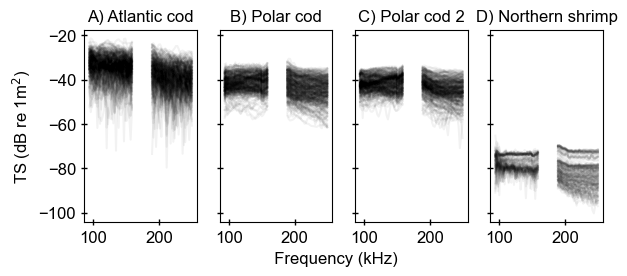

In [5]:
df_list = [a_tilt_df,p_tilt_df,p2_tilt_df,pb_tilt_df]
name_list = ['A) Atlantic cod', 'B) Polar cod', 'C) Polar cod 2', 'D) Northern shrimp']
fig,ax = plt.subplots(1,4, figsize=(two_col,2.5), sharex=True,sharey=True)
axes=ax.flatten()
c_list=[1,2,0,3]
for i_df in range(len(df_list)):
    # calculate median tilt for intervals of 10 degrees tilt
    df = df_list[i_df]
    
    ts_s = np.where(df.columns.values=='90.000')[0][0]
    ts_e = np.where(df.columns.values=='255.565')[0][0]

    df_ts = df.iloc[:,ts_s:ts_e+1]
    
    N = (len(df_ts))
    
    freqs = df_ts.columns.unique().values.astype(np.float64)
    # Plot median and CI
    #axes[i_df].plot(freqs,df_ts.mean(), c=palette[c_list[i_df]], linewidth = 2)
    axes[i_df].plot(freqs,df_ts.T, c = 'k', alpha=0.05)
    axes[i_df].set_title(name_list[i_df], fontsize=12)
    
axes[0].set_ylabel('TS (dB re 1m$^2$)', fontsize=12)
axes[1].set_xlabel('                          Frequency (kHz)', fontsize=12)
    #axes[i_df].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=13)
    
fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AFKABAN/TargetSpectra.jpeg', format='jpeg', dpi = 300, facecolor='w', bbox_inches='tight', transparent=True)

What does figure say:

- Both polar cod experiments match. Duplicable?
- Atlantic cod target spectra is more complex. More nulls and variability
- Polar cod and northern shrimp also have intensity variability but mostly consistent shape. Which seems to be "calibration" driven?
- Northern shrimp has a large distribution of intensity with 200 kHz.